# Step 2. Scenario Selection
## *Group 11. Multi-Scenario MORDM*

This notebook contains the second step of multi-scenario MORDM: scenario selection. The approach is based on Eker & Kwakkel (2018). An overview of the problem formulation (step 1) is also included for completeness.

## 0. Prepare Environment

In [1]:
# Import helping libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import networkx as nx

import copy
import sys
from sklearn import preprocessing
import itertools
import random
import time

# sns pair_plots create a lot of warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import EMA workbench functionalities
from ema_workbench import (Model, Policy, ema_logging, SequentialEvaluator, \
                           MultiprocessingEvaluator, RealParameter, ScalarOutcome,
                           Constant, Scenario, save_results, load_results)

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.evaluators import MultiprocessingEvaluator
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench.analysis import parcoords
from ema_workbench.analysis import pairs_plotting

In [3]:
# Import model libraries and functions (from parent folder)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

## 1. Problem Formulation

#### 1.1 Load the dike_model with the correct problem formulation

In [4]:
# Show progress
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [5]:
# Load the model based on a chosen problem formulation
dike_model, planning_steps = get_model_for_problem_formulation(7)

#### 1.2 Show the problem formulation

In [6]:
# Show uncertainties
# Enlist: external factor (uncertainty), their type, lower boundary, and upper boundary
for uncertainty in dike_model.uncertainties:
    print(repr(uncertainty))
    
print([u.name for u in dike_model.uncertainties])

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [7]:
# Show policy levers
# Enlist: levers, their type, lower boundary, and upper boundary
for lever in dike_model.levers:
    print(repr(lever))
    
print([l.name for l in dike_model.levers])

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)
IntegerParameter('0_RfR 1', 0, 1, resolution=None, default=None, variable_name=['0_RfR 1'], pff=False)
IntegerParameter('0_RfR 2', 0, 1, resolution=None, default=None, variable_name=['0_RfR 2'], pff=False)
IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False)
IntegerParameter('1_RfR 1', 0, 1, resolution=None, default=None, variable_name=['1_RfR 1'], pff=False)
IntegerParameter('1_RfR 2', 0, 1, resolution=None, default=None, variable_name=['1_RfR 2'], pff=False)
IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False)
IntegerParameter('2_RfR 1', 0, 1, resolution=None, default=None, variable_name=['2_RfR 1'], pff=False)
IntegerParameter('2_RfR 2', 0, 1, resolution=None, default=None, variable_name=['2_RfR 2'], pff=False)
IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable

In [8]:
# Show outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))
    
print([o.name for o in dike_model.outcomes])

ScalarOutcome('Expected Annual Damage', variable_name=('A.1_Expected Annual Damage', 'A.2_Expected Annual Damage', 'A.3_Expected Annual Damage', 'A.4_Expected Annual Damage', 'A.5_Expected Annual Damage'), function=<function sum_over at 0x0000018B52355F80>)
ScalarOutcome('Total Investment Costs', variable_name=('A.1_Dike Investment Costs', 'A.2_Dike Investment Costs', 'A.3_Dike Investment Costs', 'A.4_Dike Investment Costs', 'A.5_Dike Investment Costs', 'RfR Total Costs', 'Expected Evacuation Costs'), function=<function sum_over at 0x0000018B52355F80>)
ScalarOutcome('Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths', 'A.2_Expected Number of Deaths', 'A.3_Expected Number of Deaths', 'A.4_Expected Number of Deaths', 'A.5_Expected Number of Deaths'), function=<function sum_over at 0x0000018B52355F80>)
ScalarOutcome('A.1_Expected Annual Damage', variable_name=('A.1_Expected Annual Damage',), function=<function sum_over at 0x0000018B52355F80>)
ScalarOutcome('A.1_Tot

## 2. Scenario generation

#### 2.1 Perform experiments

In [9]:
# Running the model through EMA workbench
file_name = "results/S2_experiments_500scenarios_10policies.tar.gz"
try:
    results = load_results(file_name)
except IOError:
    with MultiprocessingEvaluator(dike_model) as evaluator:
        results = evaluator.perform_experiments(scenarios=500, policies=10)
        save_results(results, file_name)

[MainProcess/INFO] results loaded successfully from C:\Users\nicol\Delft University of Technology\Renée van der Poel - MBDM Group 1\final assignment\results\S2_experiments_500scenarios_10policies.tar.gz


In [10]:
# Retrieving the simulation runs
experiments, outcomes = results

#### 2.2 Observe result data

In [11]:
# Show the experimental conditions
print(experiments.shape)
print(experiments.columns)
experiments.head()

(5000, 53)
Index(['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'EWS_DaysToThreat', 'scenario', 'policy', 'model'],
      dtype='object')


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat,scenario,policy,model
0,43,263.334854,10.0,0.429168,247.561117,1.0,0.420359,70.392321,1.5,0.627460,...,10,0,0,4,1,9,2,10,0,dikesnet
1,17,207.049581,1.5,0.125343,322.734517,1.0,0.236677,203.431412,10.0,0.208362,...,10,0,0,4,1,9,2,11,0,dikesnet
2,2,142.540778,10.0,0.208766,283.640822,1.0,0.292590,316.316924,1.5,0.857633,...,10,0,0,4,1,9,2,12,0,dikesnet
3,88,224.836340,1.5,0.510302,347.175138,10.0,0.223723,78.892499,1.5,0.300905,...,10,0,0,4,1,9,2,13,0,dikesnet
4,10,340.413137,1.5,0.161281,189.660821,10.0,0.491369,190.225862,1.0,0.979862,...,10,0,0,4,1,9,2,14,0,dikesnet


In [12]:
# Show the outcomes
print(outcomes.keys())
outcomes

dict_keys(['Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths', 'A.1_Expected Annual Damage', 'A.1_Total Costs', 'A.1_Expected Number of Deaths', 'A.2_Expected Annual Damage', 'A.2_Total Costs', 'A.2_Expected Number of Deaths', 'A.3_Expected Annual Damage', 'A.3_Total Costs', 'A.3_Expected Number of Deaths', 'A.4_Expected Annual Damage', 'A.4_Total Costs', 'A.4_Expected Number of Deaths', 'A.5_Expected Annual Damage', 'A.5_Total Costs', 'A.5_Expected Number of Deaths'])


{'Expected Annual Damage': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.64364011e+07, 3.07051934e+08, 9.60046694e+07]),
 'Total Investment Costs': array([2.01628185e+09, 2.01628185e+09, 2.01628185e+09, ...,
        2.27737890e+09, 2.27737890e+09, 2.27737890e+09]),
 'Expected Number of Deaths': array([0.        , 0.        , 0.        , ..., 0.04716919, 0.73573114,
        0.16339523]),
 'A.1_Expected Annual Damage': array([0., 0., 0., ..., 0., 0., 0.]),
 'A.1_Total Costs': array([2.32098499e+08, 2.32098499e+08, 2.32098499e+08, ...,
        1.73820755e+08, 1.73820755e+08, 1.73820755e+08]),
 'A.1_Expected Number of Deaths': array([0., 0., 0., ..., 0., 0., 0.]),
 'A.2_Expected Annual Damage': array([       0.        ,        0.        ,        0.        , ...,
               0.        , 19227064.09417957,        0.        ]),
 'A.2_Total Costs': array([3.06529207e+08, 3.06529207e+08, 3.06529207e+08, ...,
        2.37464330e+08, 2.56691394e+08, 2.37464330e+08]),
 '

#### 2.3 Restructure the data into dataframes

In [13]:
# create a dataframe from the outcomes with an extra column with policy names
policies = experiments['policy']
data = pd.DataFrame(outcomes)
data['policy'] = policies

In [14]:
# show the data
data

,Expected Annual Damage,Total Investment Costs,Expected Number of Deaths,A.1_Expected Annual Damage,A.1_Total Costs,A.1_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Total Costs,A.2_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Total Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Total Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Total Costs,A.5_Expected Number of Deaths,policy
0,0.000000e+00,2.016282e+09,0.000000,0.0,2.320985e+08,0.0,0.000000e+00,3.065292e+08,0.000000,0.000000e+00,1.294234e+08,0.000000,0.0,2.038434e+07,0.0,0.000000e+00,1.248464e+08,0.000000,0
1,0.000000e+00,2.016282e+09,0.000000,0.0,2.320985e+08,0.0,0.000000e+00,3.065292e+08,0.000000,0.000000e+00,1.294234e+08,0.000000,0.0,2.038434e+07,0.0,0.000000e+00,1.248464e+08,0.000000,0
2,0.000000e+00,2.016282e+09,0.000000,0.0,2.320985e+08,0.0,0.000000e+00,3.065292e+08,0.000000,0.000000e+00,1.294234e+08,0.000000,0.0,2.038434e+07,0.0,0.000000e+00,1.248464e+08,0.000000,0
3,0.000000e+00,2.016282e+09,0.000000,0.0,2.320985e+08,0.0,0.000000e+00,3.065292e+08,0.000000,0.000000e+00,1.294234e+08,0.000000,0.0,2.038434e+07,0.0,0.000000e+00,1.248464e+08,0.000000,0
4,3.538953e+07,2.016283e+09,0.003924,0.0,2.320985e+08,0.0,0.000000e+00,3.065292e+08,0.000000,0.000000e+00,1.294234e+08,0.000000,0.0,2.038434e+07,0.0,3.538953e+07,1.602360e+08,0.003924,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,3.768510e+07,2.277379e+09,0.065749,0.0,1.738208e+08,0.0,0.000000e+00,2.374643e+08,0.000000,3.768510e+07,1.257719e+08,0.065749,0.0,4.690701e+07,0.0,0.000000e+00,6.929997e+07,0.000000,9
4996,2.926300e+06,2.277379e+09,0.004038,0.0,1.738208e+08,0.0,0.000000e+00,2.374643e+08,0.000000,2.926300e+06,9.101313e+07,0.004038,0.0,4.690701e+07,0.0,0.000000e+00,6.929997e+07,0.000000,9
4997,3.643640e+07,2.277379e+09,0.047169,0.0,1.738208e+08,0.0,0.000000e+00,2.374643e+08,0.000000,2.742606e+07,1.155129e+08,0.037142,0.0,4.690701e+07,0.0,9.010340e+06,7.831031e+07,0.010027,9
4998,3.070519e+08,2.277379e+09,0.735731,0.0,1.738208e+08,0.0,1.922706e+07,2.566914e+08,0.027163,2.878249e+08,3.759117e+08,0.708568,0.0,4.690701e+07,0.0,0.000000e+00,6.929997e+07,0.000000,9


#### 2.4 First selection of scenarios, based on policy-relevance 

Policy-relevant failure scenarios are chosen based on the policy objectives of the Delta Commission. Results are filtered based on the aggregate outcomes of deaths, costs, and damages. The 75th percentile is used as a cut-off point for each outcome. These are scenarios in which there are many deaths, high costs, and lots of damage. Since a key priority of the Delta Commission is to keep deaths at a minimum, deaths disaggregated over the dike areas are considered as well.

In [15]:
# Set the threshold values
thresholds_deaths = (data['Expected Number of Deaths'] > np.percentile(data['Expected Number of Deaths'], 75)) | \
                    (data['A.1_Expected Number of Deaths'] > np.percentile(data['A.1_Expected Number of Deaths'], 75)) | \
                    (data['A.2_Expected Number of Deaths'] > np.percentile(data['A.2_Expected Number of Deaths'], 75)) | \
                    (data['A.3_Expected Number of Deaths'] > np.percentile(data['A.3_Expected Number of Deaths'], 75)) | \
                    (data['A.4_Expected Number of Deaths'] > np.percentile(data['A.4_Expected Number of Deaths'], 75)) | \
                    (data['A.5_Expected Number of Deaths'] > np.percentile(data['A.5_Expected Number of Deaths'], 75))
    
thresholds_costs = (data['Total Investment Costs'] > np.percentile(data['Total Investment Costs'], 75))
thresholds_damage = (data['Expected Annual Damage'] > np.percentile(data['Expected Annual Damage'], 75))

# Select those results (scenarios) that meet the threshold values
relevant_scenarios = data[thresholds_deaths & thresholds_costs & thresholds_damage]

# Create dataframes with the relevant outcomes, and all outcomes
relevant_scenarios = relevant_scenarios.loc[:, [o.name for o in dike_model.outcomes]]
all_scenarios = data.loc[:, [o.name for o in dike_model.outcomes]]

In [16]:
# Show the effect of the policy-relevance selection
print(all_scenarios.shape)
print(relevant_scenarios.shape)

(5000, 18)
(198, 18)


In [17]:
relevant_scenarios.head()

,Expected Annual Damage,Total Investment Costs,Expected Number of Deaths,A.1_Expected Annual Damage,A.1_Total Costs,A.1_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Total Costs,A.2_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Total Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Total Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Total Costs,A.5_Expected Number of Deaths
4,3.538953e+07,2.016283e+09,0.003924,0.0,2.320985e+08,0.0,0.0,3.065292e+08,0.0,0.000000e+00,1.294234e+08,0.000000,0.0,2.038434e+07,0.0,3.538953e+07,1.602360e+08,0.003924
11,1.620452e+08,2.016291e+09,0.022372,0.0,2.320985e+08,0.0,0.0,3.065292e+08,0.0,0.000000e+00,1.294234e+08,0.000000,0.0,2.038434e+07,0.0,1.620452e+08,2.868917e+08,0.022372
29,5.730463e+07,2.016285e+09,0.008526,0.0,2.320985e+08,0.0,0.0,3.065292e+08,0.0,0.000000e+00,1.294234e+08,0.000000,0.0,2.038434e+07,0.0,5.730463e+07,1.821511e+08,0.008526
32,5.163454e+07,2.016283e+09,0.009697,0.0,2.320985e+08,0.0,0.0,3.065292e+08,0.0,5.163454e+07,1.810579e+08,0.009697,0.0,2.038434e+07,0.0,0.000000e+00,1.248464e+08,0.000000
47,5.891675e+07,2.016285e+09,0.007893,0.0,2.320985e+08,0.0,0.0,3.065292e+08,0.0,2.150142e+06,1.315735e+08,0.000556,0.0,2.038434e+07,0.0,5.676661e+07,1.816130e+08,0.007338


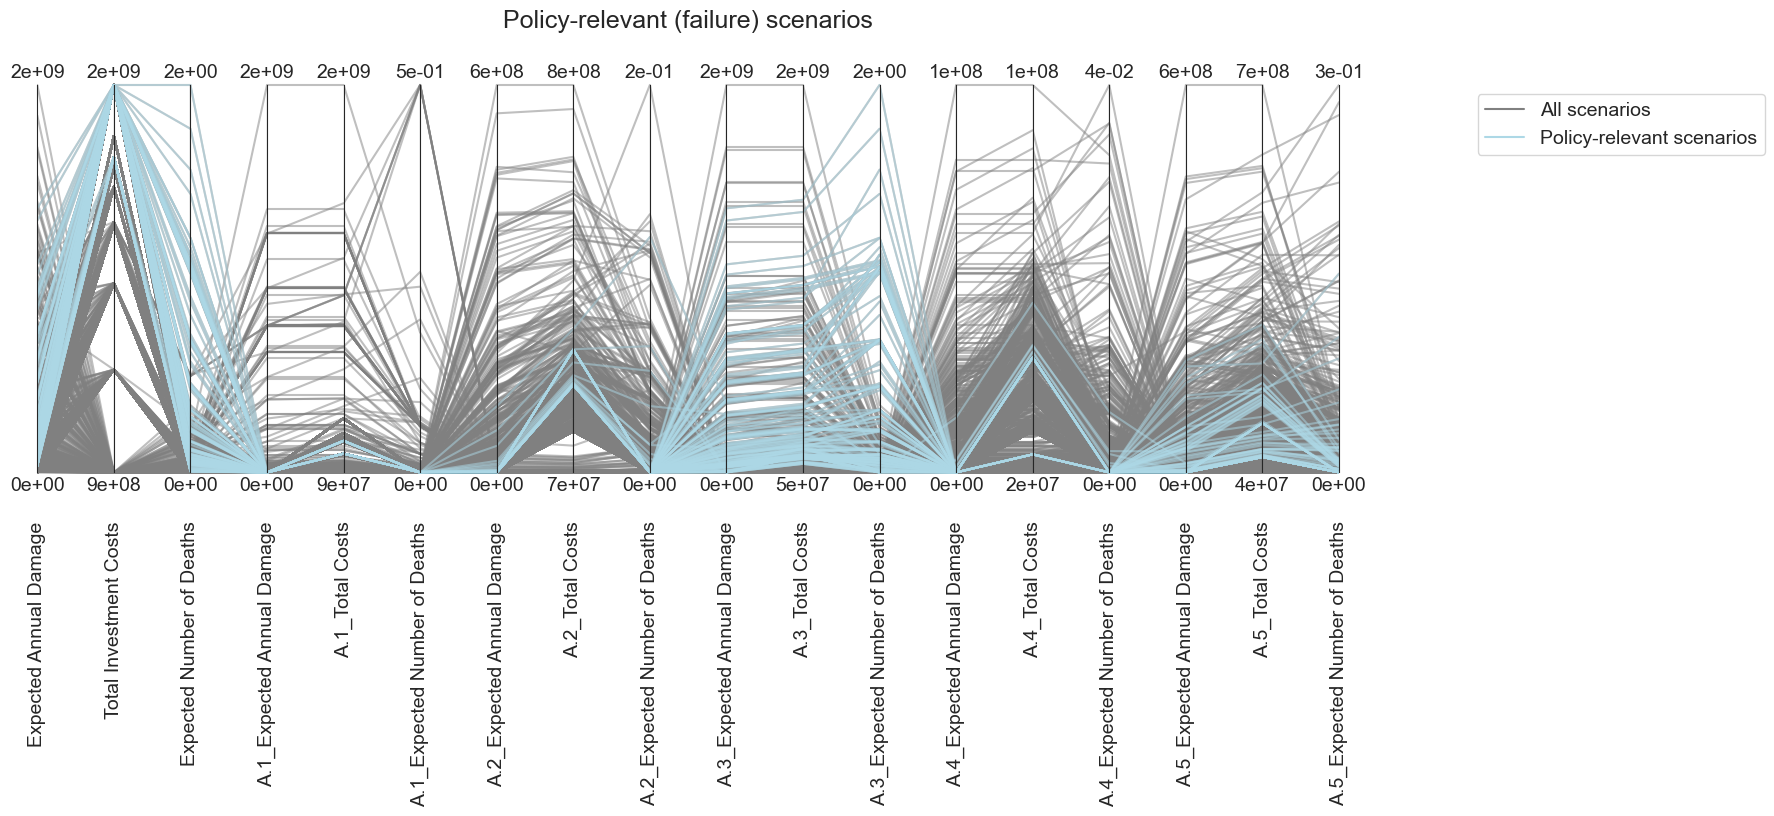

In [18]:
# Parallel coordinate plots: visualize the policy relevant scenarios

# set limits
limits = parcoords.get_limits(all_scenarios)

# create plot
paraxes = parcoords.ParallelAxes(limits, formatter={o.name:".0e" for o in dike_model.outcomes})
paraxes.plot(all_scenarios, color='grey', alpha=0.5, label="All scenarios")
paraxes.plot(relevant_scenarios, color='lightblue', alpha=0.5, label="Policy-relevant scenarios")
paraxes.legend()

# show plot
fig = paraxes.fig
fig.set_size_inches(15, 15)
fig.suptitle("Policy-relevant (failure) scenarios", fontsize=18)
plt.savefig("figures/S2_parcoords_policy-relevant-scenarios.png", dpi=300, bbox_inches='tight')
plt.show()

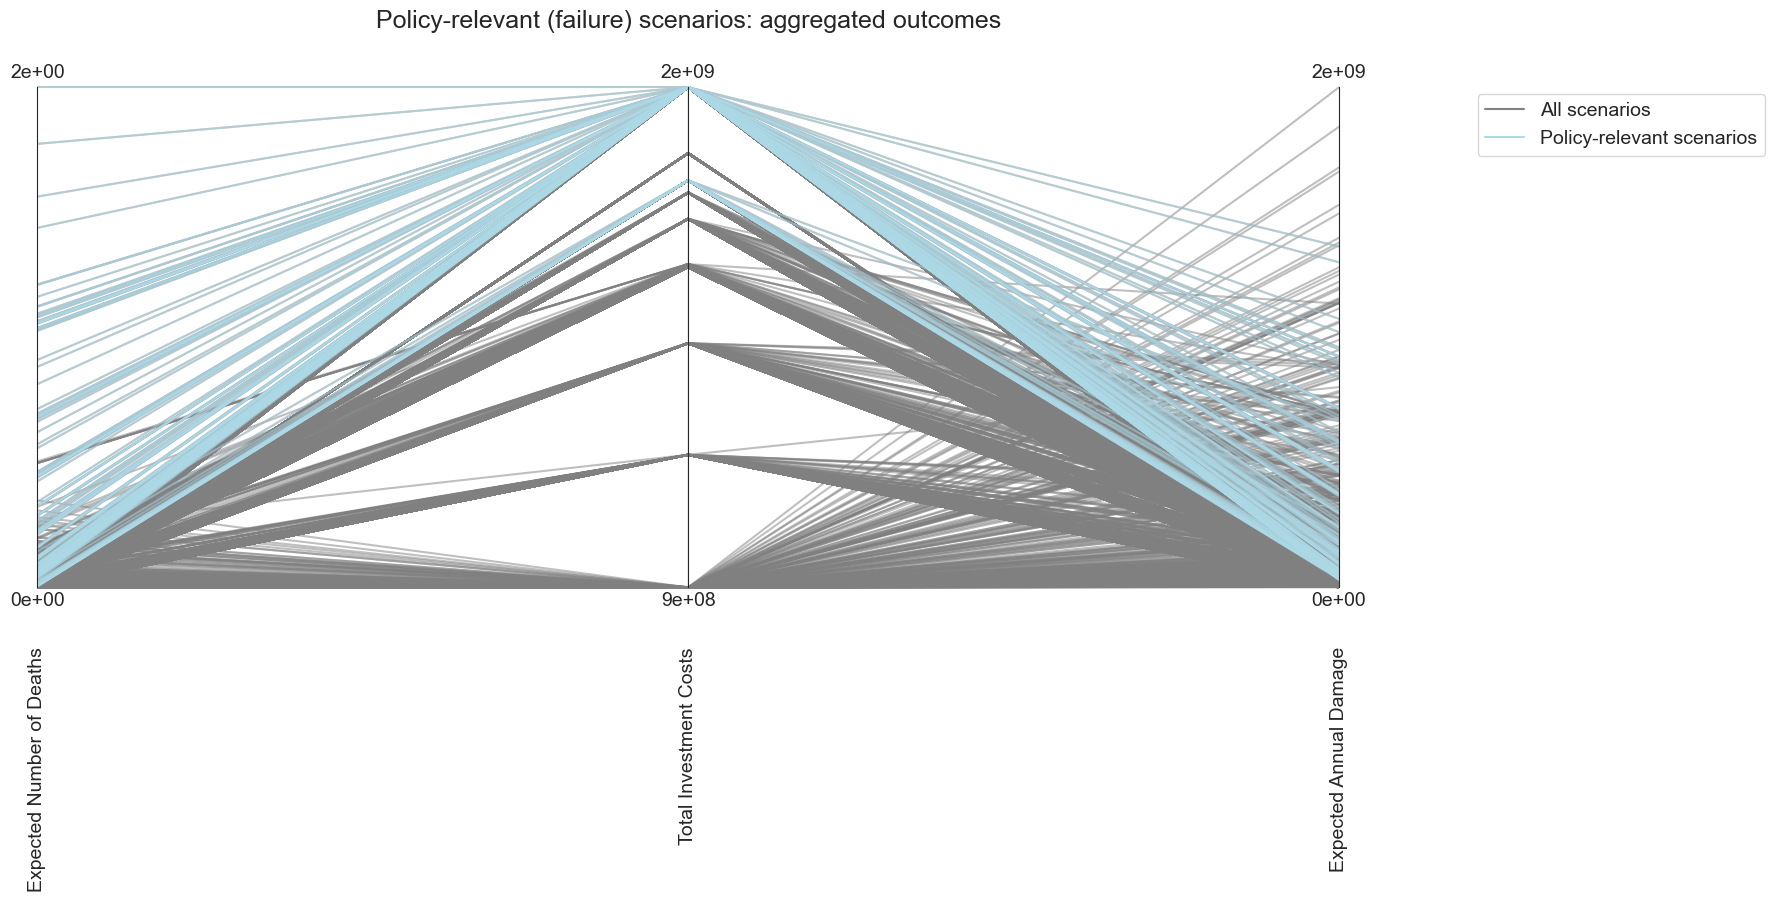

In [19]:
# Parallel coordinate plots: visualize the policy relevant scenarios
selected_outcomes = ['Expected Number of Deaths','Total Investment Costs', 'Expected Annual Damage']

# set limits
limits = parcoords.get_limits(all_scenarios[selected_outcomes])
#limits.loc[0, [o.name for o in dike_model.outcomes]] = 0

# create plot
paraxes = parcoords.ParallelAxes(limits, formatter={o.name:".0e" for o in dike_model.outcomes})
paraxes.plot(all_scenarios[selected_outcomes], color='grey', alpha=0.5, label="All scenarios")
paraxes.plot(relevant_scenarios[selected_outcomes], color='lightblue', alpha=0.5, label="Policy-relevant scenarios")
paraxes.legend()

# show plot
fig = paraxes.fig
fig.set_size_inches(15, 15)
fig.suptitle("Policy-relevant (failure) scenarios: aggregated outcomes", fontsize=18)
plt.savefig("figures/S2_parcoords_policy-relevant-scenarios_agg-outcomes.png", dpi=300, bbox_inches='tight')
plt.show()

#### 2.5 Create a final selection of scenarios, based on worst case scenarios

Out of the policy-relevant scenarios, select the worst cases for further analysis.

In [20]:
# Get the unique indices for the maximal outcomes across all objectives
selected_indices = pd.concat([relevant_scenarios.idxmax()]).unique()

In [21]:
# Identify the selected scenarios (their outcomes)
selected_scenarios_outcomes = relevant_scenarios.loc[selected_indices]
selected_scenarios_outcomes

,Expected Annual Damage,Total Investment Costs,Expected Number of Deaths,A.1_Expected Annual Damage,A.1_Total Costs,A.1_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Total Costs,A.2_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Total Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Total Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Total Costs,A.5_Expected Number of Deaths
4991,1.303367e+09,2.277379e+09,2.063089,0.0,1.738208e+08,0.0,0.000000e+00,2.374643e+08,0.000000,1.303367e+09,1.391454e+09,2.063089,0.000000e+00,4.690701e+07,0.00000,0.000000e+00,6.929997e+07,0.000000
4501,3.509834e+07,2.277379e+09,0.091886,0.0,1.738208e+08,0.0,0.000000e+00,2.374643e+08,0.000000,3.509834e+07,1.231852e+08,0.091886,0.000000e+00,4.690701e+07,0.00000,0.000000e+00,6.929997e+07,0.000000
4,3.538953e+07,2.016283e+09,0.003924,0.0,2.320985e+08,0.0,0.000000e+00,3.065292e+08,0.000000,0.000000e+00,1.294234e+08,0.000000,0.000000e+00,2.038434e+07,0.00000,3.538953e+07,1.602360e+08,0.003924
4626,4.512094e+08,2.277379e+09,0.640515,0.0,1.738208e+08,0.0,1.096930e+08,3.471573e+08,0.096327,3.415164e+08,4.296033e+08,0.544188,0.000000e+00,4.690701e+07,0.00000,0.000000e+00,6.929997e+07,0.000000
4754,3.657212e+07,2.277379e+09,0.028561,0.0,1.738208e+08,0.0,8.178488e+06,2.456428e+08,0.007665,0.000000e+00,8.808683e+07,0.000000,1.498183e+07,6.188884e+07,0.00607,1.341180e+07,8.271178e+07,0.014826
11,1.620452e+08,2.016291e+09,0.022372,0.0,2.320985e+08,0.0,0.000000e+00,3.065292e+08,0.000000,0.000000e+00,1.294234e+08,0.000000,0.000000e+00,2.038434e+07,0.00000,1.620452e+08,2.868917e+08,0.022372
4511,2.230626e+08,2.277379e+09,0.253820,0.0,1.738208e+08,0.0,0.000000e+00,2.374643e+08,0.000000,6.946939e+07,1.575562e+08,0.117218,0.000000e+00,4.690701e+07,0.00000,1.535933e+08,2.228932e+08,0.136602


In [22]:
# Identify the selected scenarios (their combination of uncertainties)
selected_scenarios_uncertainties = experiments.iloc[selected_indices]
selected_scenarios_uncertainties = selected_scenarios_uncertainties.loc[:, [o.name for o in dike_model.uncertainties]]
selected_scenarios_uncertainties = selected_scenarios_uncertainties.drop_duplicates()
selected_scenarios_uncertainties

,discount rate 0,discount rate 1,discount rate 2,A.0_ID flood wave shape,A.1_Bmax,A.1_pfail,A.1_Brate,A.2_Bmax,A.2_pfail,A.2_Brate,A.3_Bmax,A.3_pfail,A.3_Brate,A.4_Bmax,A.4_pfail,A.4_Brate,A.5_Bmax,A.5_pfail,A.5_Brate
4991,2.5,2.5,2.5,108,153.712598,0.720430,10.0,278.172421,0.932426,10.0,144.489369,0.001003,1.0,304.881998,0.208452,1.0,142.107199,0.891713,1.0
4501,4.5,3.5,3.5,17,207.049581,0.125343,1.5,322.734517,0.236677,1.0,203.431412,0.208362,10.0,146.833059,0.507869,1.0,344.819466,0.582273,10.0
4,1.5,2.5,1.5,10,340.413137,0.161281,1.5,189.660821,0.491369,10.0,190.225862,0.979862,1.0,145.527802,0.989501,10.0,347.380540,0.040570,1.0
4626,2.5,2.5,3.5,93,334.901995,0.384096,1.0,240.816323,0.000773,1.0,283.970527,0.088837,1.0,330.170098,0.177877,1.5,252.059626,0.641829,1.5
4754,2.5,3.5,3.5,22,299.846369,0.221897,1.0,200.247882,0.022809,1.5,238.148021,0.814192,1.0,337.812001,0.005051,1.5,60.113426,0.029884,1.0
11,2.5,3.5,1.5,75,42.710561,0.020568,1.0,57.325299,0.566387,1.0,184.160866,0.174143,10.0,118.075493,0.535082,10.0,111.915792,0.000997,1.0


In [23]:
# List the indeces of the chosen scenarios
list(selected_scenarios_uncertainties.index.values)

[4991, 4501, 4, 4626, 4754, 11]

In [24]:
# For visualization: identify the outcomes of this final selection
selected_scenarios = selected_scenarios_outcomes.loc[selected_scenarios_uncertainties.index.values]

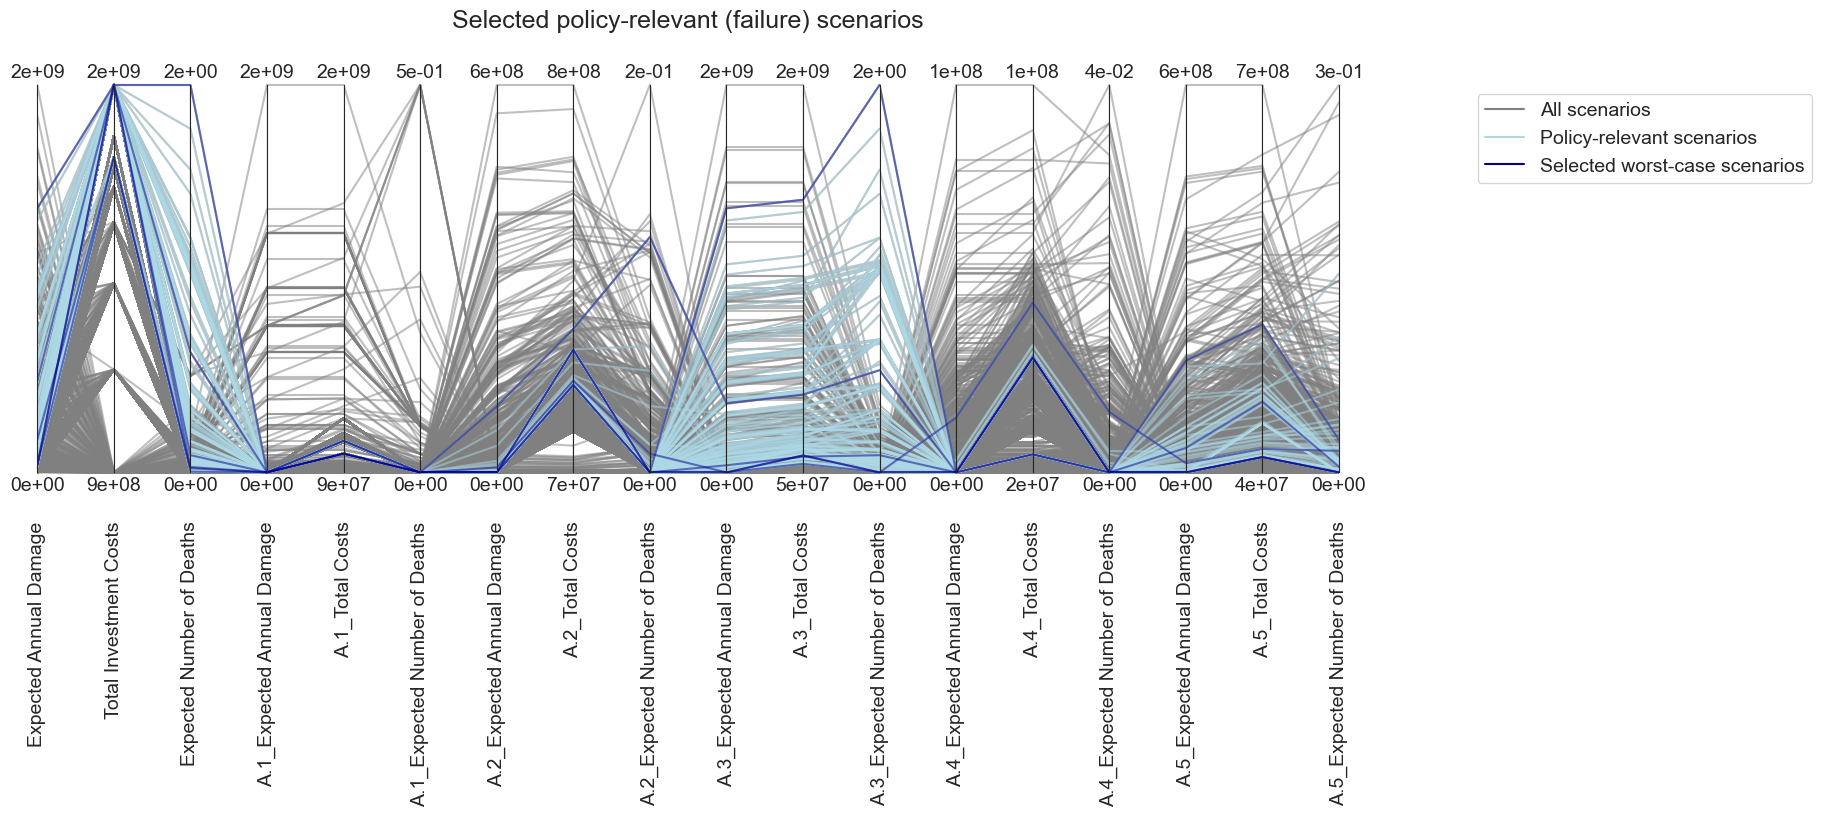

In [25]:
# Parallel coordinate plots: visualize the selected scenarios

# set limits
limits = parcoords.get_limits(all_scenarios)

# create plot
paraxes = parcoords.ParallelAxes(limits, formatter={o.name:".0e" for o in dike_model.outcomes})
paraxes.plot(all_scenarios, color='grey', alpha=0.5, label="All scenarios")
paraxes.plot(relevant_scenarios, color='lightblue', alpha=0.5, label="Policy-relevant scenarios")
paraxes.plot(selected_scenarios, color='darkblue', alpha=0.5, label="Selected worst-case scenarios")
paraxes.legend()

# show plot
fig = paraxes.fig
fig.set_size_inches(15, 15)
fig.suptitle("Selected policy-relevant (failure) scenarios", fontsize=18)
plt.savefig("figures/S2_parcoords_selected-scenarios.png", dpi=300, bbox_inches='tight')
plt.show()

#### 2.6 Save the selected scenarios to a csv file

In [26]:
scenarios_file_name = "results/S2_selected_scenarios.csv"
selected_scenarios_uncertainties.to_csv(scenarios_file_name)

## Step 3. Generating Candidate Solutions
#### *See script: G11_S3_GeneratingCandidateSolutions.ipynb*